## **Installs**

In [1]:
!pip install simfin

     |████████████████████████████████| 60 kB 3.1 MB/s 


# **Imports**

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns

# Scikit-learn imports.
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import export_text
from sklearn.metrics import confusion_matrix
from sklearn.metrics import r2_score, accuracy_score

# Import the main functionality from the SimFin Python API.
import simfin as sf

# Import names used for easy access to SimFin's data-columns.
from simfin.names import *

In [3]:
# Version of the SimFin Python API.
sf.__version__

'0.8.1'

## **SimFin Config**

In [4]:
# SimFin data-directory.
sf.set_data_dir('~/simfin_data/')

In [5]:
# SimFin load API key or use free data.
sf.load_api_key(path='~/simfin_api_key.txt', default_key='free')

In [6]:
# Seaborn set plotting style.
sns.set_style("whitegrid")

## **Data Hub**

In [7]:
# We are interested in the US stock-market.
market = 'us'

# Add this date-offset to the fundamental data such as
# Income Statements etc., because the REPORT_DATE is not
# when it was actually made available to the public,
# which can be 1, 2 or even 3 months after the Report Date.
offset = pd.DateOffset(days=60)

# Refresh the fundamental datasets (Income Statements etc.)
# every 30 days.
refresh_days = 30

# Refresh the dataset with shareprices every 10 days.
refresh_days_shareprices = 10

In [8]:
%%time
hub = sf.StockHub(market=market, offset=offset,
                  refresh_days=refresh_days,
                  refresh_days_shareprices=refresh_days_shareprices)

CPU times: user 12 µs, sys: 6 µs, total: 18 µs
Wall time: 20.3 µs


## **Signals**

First we calculate financial signals for the stocks, such as the Current Ratio, Debt Ratio, Net Profit Margin, Return on Assets, etc. These are calculated using data from the financial reports: Income Statements, Balance Sheets and Cash-Flow Statements, which are automatically downloaded and loaded by the data-hub.

In [9]:
%%time
df_fin_signals = hub.fin_signals(variant='daily')

Dataset "us-income-ttm" not on disk.
- Downloading ... 100.0%
- Extracting zip-file ... Done!
- Loading from disk ... Done!
Dataset "us-balance-ttm" not on disk.
- Downloading ... 100.0%
- Extracting zip-file ... Done!
- Loading from disk ... Done!
Dataset "us-cashflow-ttm" not on disk.
- Downloading ... 100.0%
- Extracting zip-file ... Done!
- Loading from disk ... Done!
Dataset "us-shareprices-daily" not on disk.
- Downloading ... 100.0%
- Extracting zip-file ... Done!
- Loading from disk ... Done!
Cache-file 'fin_signals-2a38bb7d.pickle' not on disk.
- Running function fin_signals() ... 

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Done!
- Saving cache-file to disk ... Done!
CPU times: user 2min 54s, sys: 11.9 s, total: 3min 6s
Wall time: 3min 11s


Now we calculate growth signals for the stocks, such as Earnings Growth, FCF Growth, Sales Growth, etc. These are also calculated using data from the financial reports: Income Statements, Balance Sheets and Cash-Flow Statements, which are automatically downloaded and loaded by the data-hub.

In [10]:
%%time
df_growth_signals = hub.growth_signals(variant='daily')

Dataset "us-income-quarterly" not on disk.
- Downloading ... 100.0%
- Extracting zip-file ... Done!
- Loading from disk ... Done!
Dataset "us-balance-quarterly" not on disk.
- Downloading ... 100.0%
- Extracting zip-file ... Done!
- Loading from disk ... Done!
Dataset "us-cashflow-quarterly" not on disk.
- Downloading ... 100.0%
- Extracting zip-file ... Done!
- Loading from disk ... Done!
Cache-file 'growth_signals-2a38bb7d.pickle' not on disk.
- Running function growth_signals() ... Done!
- Saving cache-file to disk ... Done!
CPU times: user 1min 36s, sys: 6.67 s, total: 1min 42s
Wall time: 1min 46s


Now we calculate valuation signals for the stocks, such as P/E, P/Sales, etc. These are calculated from the share-prices and data from the financial reports. Because the data-hub has already loaded the required datasets in the function-calls above, the data is merely reused here, and the data-hub can proceed directly to computing the signals.

In [11]:
%%time
df_val_signals = hub.val_signals(variant='daily')

Cache-file 'val_signals-739b68a6.pickle' not on disk.
- Running function val_signals() ... Done!
- Saving cache-file to disk ... Done!
CPU times: user 2min 27s, sys: 5.04 s, total: 2min 32s
Wall time: 2min 30s


We now combine all the signals into a single DataFrame:

In [12]:
%%time
# Combine the DataFrames.
dfs = [df_fin_signals, df_growth_signals, df_val_signals]
df_signals = pd.concat(dfs, axis=1)

CPU times: user 2.16 s, sys: 22.3 ms, total: 2.18 s
Wall time: 2.17 s


In [13]:
df_signals.dropna(how='all').tail()

(Dividends + Share Buyback) / FCF  ...  Price to Book Value
Ticker Date                                           ...                     
ZYXI   2020-07-31                          -0.091642  ...            27.959555
       2020-08-03                          -0.091642  ...            27.623221
       2020-08-04                          -0.091642  ...            26.394872
       2020-08-05                          -0.091642  ...            26.497235
       2020-08-06                          -0.091642  ...            24.596219

[5 rows x 42 columns]

## **Missing Data**

Some of the signals have a lot of missing data which cannot be handled by scikit-learn. Below is the fraction of each signal-column that is missing:

In [14]:
# Remove all rows with only NaN values.
df = df_signals.dropna(how='all').reset_index(drop=True)

# For each column, show the fraction of the rows that are NaN.
(df.isnull().sum() / len(df)).sort_values(ascending=False)

R&D / Revenue                        0.609849
R&D / Gross Profit                   0.609710
Return on Research Capital           0.609710
Dividend Yield                       0.441065
Inventory Turnover                   0.289154
Debt Ratio                           0.264525
Net Acquisitions / Total Assets      0.261299
Sales Growth YOY                     0.155158
Sales Growth                         0.145834
FCF Growth YOY                       0.145031
Assets Growth YOY                    0.145016
Earnings Growth YOY                  0.145016
Assets Growth                        0.137141
Earnings Growth                      0.137141
FCF Growth                           0.137141
Interest Coverage                    0.099638
Sales Growth QOQ                     0.063761
Earnings Growth QOQ                  0.051099
Assets Growth QOQ                    0.051099
FCF Growth QOQ                       0.051099
CapEx / (Depr + Amor)                0.039883
P/Sales                           

We removed all signals that have more than 25% missing data:

In [15]:
# List of the columns before removing any.
columns_before = df_signals.columns

# Threshold for the number of rows that must be NaN for each column.
thresh = 0.75 * len(df_signals.dropna(how='all'))

# Remove all columns which don't have sufficient data.
df_signals = df_signals.dropna(axis='columns', thresh=thresh)

# List of the columns after the removal.
columns_after = df_signals.columns

# Show the columns that were removed.
columns_before.difference(columns_after)

Index(['Debt Ratio', 'Dividend Yield', 'Inventory Turnover',
       'Net Acquisitions / Total Assets', 'R&D / Gross Profit',
       'R&D / Revenue', 'Return on Research Capital'],
      dtype='object')

## **1-3 Year Returns**

We want to try and predict the average 1-3 year returns by considering the mean log-returns.

In [16]:
# Name of the new column for the returns.
TOTAL_RETURN_1_3Y = 'Total Return 1-3 Years'

In [17]:
%%time
# Calculate the mean log-returns for all 1-3 year periods.
df_returns_1_3y = \
    hub.mean_log_returns(name=TOTAL_RETURN_1_3Y,
                         future=True, annualized=True,
                         min_years=1, max_years=3)

Cache-file 'mean_log_change-5cec82bd.pickle' not on disk.
- Running function mean_log_change() ... Done!
- Saving cache-file to disk ... Done!
CPU times: user 52.1 s, sys: 411 ms, total: 52.5 s
Wall time: 52.3 s


In [18]:
df_returns_1_3y

Ticker  Date      
A       2007-01-03   -0.147205
        2007-01-04   -0.149268
        2007-01-05   -0.144580
        2007-01-08   -0.143036
        2007-01-09   -0.144187
                        ...   
ZYXI    2020-07-31         NaN
        2020-08-03         NaN
        2020-08-04         NaN
        2020-08-05         NaN
        2020-08-06         NaN
Name: Total Return 1-3 Years, Length: 6952738, dtype: float64

## **Combine Signals and Returns**

We then combine the signals and returns into a single DataFrame to align the data.

In [19]:
%%time
dfs = [df_signals, df_returns_1_3y]
df_sig_rets = pd.concat(dfs, axis=1)

CPU times: user 2.04 s, sys: 17.4 ms, total: 2.06 s
Wall time: 2.04 s


In [20]:
df_sig_rets.shape

(6952738, 36)

## **Data Cleaning**

The data also contains outliers and still has missing values, so we used a common method for removing outliers which is called Winsorization of the data. It limits or clips the data between e.g. the 5% and 95% quantiles of the data. We have Winsorized both the stock-returns and all the signals. After that, we removed all rows with missing values, because scikit-learn cannot handle that. Finally we removed tickers that have less than 200 rows of data.

There were more than 6 million data-rows before this cleaning:

In [21]:
%%time

# Clip the signals and returns at their 5% and 95% quantiles.
# We do not set them to NaN because it would remove too much data.
df_sig_rets = sf.winsorize(df_sig_rets)

# Remove all rows with missing values (NaN)
# because scikit-learn cannot handle that.
df_sig_rets = df_sig_rets.dropna(how='any')

# Remove all tickers which have less than 200 data-rows.
df_sig_rets = df_sig_rets.groupby(TICKER) \
                .filter(lambda df: len(df)>200)

CPU times: user 23.2 s, sys: 2.63 s, total: 25.9 s
Wall time: 22.9 s


In [22]:
df_sig_rets.shape

(1754286, 36)

The reason that so many rows have been removed, is that scikit-learn cannot handle rows with missing values (NaN). Some missing values could be set to a default value, e.g. the Dividend Yield could be set to 0. Other columns could be omitted because they don't have any predictive power anyway. 

## **Correlation: Signals vs. Return**

The linear correlation between the signals and stock-returns can be used to assess which signals might be the best predictors for stock-returns.

A correlation value of +1 means the two variables are perfectly correlated, so they always increase and decrease together in a linear way. Conversely, a correlation value of -1 means the two variables are perfectly inversely correlated, so they always increase and decrease in the opposite direction of each other. A correlation value of zero means that there is no linear relation between the signal and stock-returns, but there may still be a strong non-linear relation.

We use the Winsorized data when studying the correlation, because data-outliers may falsely indicate a strong overall correlation, when in fact there is no correlation for the majority of the data.

The following calculates the correlation between all the signals and the 1-3 year average stock-returns, sorted according to the absolute correlation strength:

In [23]:
# New column-name for correlation between signals and returns.
RETURN_CORR = 'Return Correlation'

# Calculate the correlation between all data-columns.
df_corr = df_sig_rets.corr()

# Correlation between signals and returns.
# Sorted to show the strongest absolute correlations first.
df_corr_returns = df_corr[TOTAL_RETURN_1_3Y] \
                    .abs() \
                    .drop(TOTAL_RETURN_1_3Y) \
                    .sort_values(ascending=False) \
                    .rename(RETURN_CORR)

# Show the correlations between signals and returns.
df_corr_returns

Net Profit Margin                    0.179823
Return on Assets                     0.169738
Earnings Yield                       0.153571
Log Revenue                          0.127872
Return on Equity                     0.121230
FCF Yield                            0.115599
P/E                                  0.077106
P/FCF                                0.066776
Current Ratio                        0.060111
P/Sales                              0.057554
Market-Cap                           0.054481
Dividends / FCF                      0.053831
Quick Ratio                          0.042061
Price to Book Value                  0.038819
(Dividends + Share Buyback) / FCF    0.036685
CapEx / (Depr + Amor)                0.036108
Asset Turnover                       0.030061
FCF Growth                           0.029083
P/NCAV                               0.028812
Share Buyback / FCF                  0.027415
Assets Growth                        0.025805
Assets Growth YOY                 

## **Split Training / Test-Sets**

If we randomly divide all the data-rows into training- and test-sets, we would most likely get data for every stock-ticker in both the training- and test-sets, which would probably make them highly correlated. To avoid this, we split the dataset according to stock-tickers, so a ticker belongs to either the training- or test-set, but not both. We use 80% of all the tickers in the training-set, and 20% in the test-set.

In [24]:
# List of all unique stock-tickers in the dataset.
tickers = df_sig_rets.reset_index()[TICKER].unique()

# Split the tickers into training- and test-sets.
tickers_train, tickers_test = \
    train_test_split(tickers, train_size=0.8, random_state=1234)

Now that we have lists of tickers for the training- and test-sets, we then selected those rows from the DataFrame with signals and stock-returns:

In [25]:
%%time
df_train = df_sig_rets.loc[tickers_train]
df_test = df_sig_rets.loc[tickers_test]

CPU times: user 264 ms, sys: 54.3 ms, total: 319 ms
Wall time: 317 ms


We then split these DataFrames into signals and stock-returns; that is, X and y-values that the Machine Learning model must try and find a mapping between. 

In [26]:
# DataFrames with signals for training- and test-sets.
X_train = df_train.drop(columns=[TOTAL_RETURN_1_3Y])
X_test = df_test.drop(columns=[TOTAL_RETURN_1_3Y])

# DataFrames with stock-returns for training- and test-sets.
y_train = df_train[TOTAL_RETURN_1_3Y]
y_test = df_test[TOTAL_RETURN_1_3Y]

In [27]:
X_train.shape, y_train.shape

((1397670, 35), (1397670,))

In [28]:

X_test.shape, y_test.shape

((356616, 35), (356616,))

## **Helper Functions**

The following are helper-functions for printing and plotting the results.

In [29]:
# List of signal names.
signal_names = X_train.columns.values

# List of signal names where spaces are replaced with _
signal_names_ = [s.replace(' ', '_') for s in signal_names]

In [30]:
# Column-name.
FEATURE_IMPORTANCE = 'Feature Importance'

In [31]:
def compare_feature_imp_corr(estimator):
    """
    Return a DataFrame which compares the signals' Feature
    Importance in the Machine Learning model, to the absolute
    correlation of the signals and stock-returns.
    
    :param estimator: Sklearn ensemble estimator.
    :return: Pandas DataFrame.
    """
    
    # Wrap the list of Feature Importance in a Pandas Series.
    df_feat_imp = pd.Series(estimator.feature_importances_,
                            index=signal_names,
                            name=FEATURE_IMPORTANCE)

    # Concatenate the DataFrames with Feature Importance
    # and Return Correlation.
    dfs = [df_feat_imp, df_corr_returns]
    df_compare = pd.concat(dfs, axis=1, sort=True)
    
    # Sort by Feature Importance.
    df_compare.sort_values(by=FEATURE_IMPORTANCE,
                           ascending=False, inplace=True)
    
    return df_compare

In [32]:
def print_tree(estimator, max_depth=6, **kwargs):
    """
    Print the first Decision Tree from a Random Forest.
    :param estimator: Sklearn ensemble estimator.
    """
    s = export_text(estimator.estimators_[0],
                    max_depth=max_depth,
                    feature_names=signal_names_,
                    **kwargs)
    print(s)

In [33]:
def plot_confusion_matrix(y_true, y_pred):
    """
    Plot a classification confusion matrix.
    
    :param y_true: Array of true classes.
    :param y_pred: Array of predicted classes.
    """
    
    # Class labels.
    labels = [1.0, -1.0]
    labels_text = ['Gain', 'Loss']

    # Create confusion matrix.
    mat = confusion_matrix(y_true=y_true, y_pred=y_pred,
                           labels=labels)
    
    # Normalize so all matrix entries sum to 1.0
    mat = mat / len(y_true)
    
    # Plot the matrix as a heatmap.
    sns.heatmap(mat, robust=True,
                xticklabels=labels_text,
                yticklabels=labels_text)

## **Machine Learning: Regression**

Because we want to map financial signals x to stock-returns y that are continuous values, we used a Regression model. For this model, we used a Random Forest which is an ensemble of many Decision Trees, because it computes fairly quickly. The Decision Tree is shown further below, after the model has been fitted to the training-data.

In [34]:
# Parameters for scikit-learn's Random Forest models.
model_args = \
{
    # Random Forest parameters to adjust between
    # over- and under-fitting.
    'n_estimators': 100,
    'max_depth': 20,
    'min_samples_split': 100,
    'min_samples_leaf': 10,

    # Use all available CPU cores.
    'n_jobs': -1,

    # Set random seed to make the experiments repeatable.
    'random_state': 1234,
}

In [35]:
# Create the estimator, but don't do any computations yet.
regr = RandomForestRegressor(**model_args)

In [36]:
%%time
# Fit the estimator to the training-data.
# This may take several minutes on a 4-core CPU.
_ = regr.fit(X=X_train, y=y_train)

CPU times: user 1h 45min 33s, sys: 2.85 s, total: 1h 45min 36s
Wall time: 26min 44s


Now that the Random Forest model has been fitted to the training-data, we present one of the 100 Decision Trees that it found. These are deeply nested if-then-else statements on the signals, which result in some output value. The output of 100 such Decision Trees are averaged to create the output of the entire ensemble known as a Random Forest.

This model, however, does not contain any profound insight. It does not understand anything about finance. The model has just found that it could estimate the mapping between signals x and stock-returns y in the training-data, using many of these finely tuned if-then-else statements.

In [37]:
print_tree(regr)

|--- Net_Profit_Margin <= -0.26
|   |--- Log_Revenue <= 8.08
|   |   |--- P/FCF <= -1.65
|   |   |   |--- Asset_Turnover <= 0.50
|   |   |   |   |--- CapEx_/_(Depr_+_Amor) <= 0.07
|   |   |   |   |   |--- Gross_Profit_Margin <= 0.23
|   |   |   |   |   |   |--- Return_on_Assets <= -0.41
|   |   |   |   |   |   |   |--- truncated branch of depth 3
|   |   |   |   |   |   |--- Return_on_Assets >  -0.41
|   |   |   |   |   |   |   |--- truncated branch of depth 4
|   |   |   |   |   |--- Gross_Profit_Margin >  0.23
|   |   |   |   |   |   |--- FCF_Growth_YOY <= 0.82
|   |   |   |   |   |   |   |--- truncated branch of depth 13
|   |   |   |   |   |   |--- FCF_Growth_YOY >  0.82
|   |   |   |   |   |   |   |--- truncated branch of depth 5
|   |   |   |   |--- CapEx_/_(Depr_+_Amor) >  0.07
|   |   |   |   |   |--- Earnings_Growth_QOQ <= -0.23
|   |   |   |   |   |   |--- Current_Ratio <= 7.84
|   |   |   |   |   |   |   |--- truncated branch of depth 14
|   |   |   |   |   |   |--- Current_

Shown below is the mutual importance of the signals (aka. features) in the model, and the comparison to their correlation with the stock-returns. The signals with highest correlations to the future stock-returns, are not necessarily the ones that were most important to the model. But correlation only measures the linear relation between signals and stock-returns, while the Random Forest can find complicated non-linear relations.

In [38]:
compare_feature_imp_corr(regr)

,Feature Importance,Return Correlation
Gross Profit Margin,0.061551,0.011505
Log Revenue,0.057134,0.127872
Net Profit Margin,0.056160,0.179823
Asset Turnover,0.053031,0.030061
Market-Cap,0.046324,0.054481
CapEx / (Depr + Amor),0.043374,0.036108
Interest Coverage,0.039237,0.012846
Quick Ratio,0.038460,0.042061
Current Ratio,0.035778,0.060111
P/Cash,0.033710,0.015078


## **Regression Results**
Shown below is how the Machine Learning model performed. First we used the fitted model to predict the stock-returns for the training- and test-sets:

In [39]:
%%time
y_train_pred = regr.predict(X_train)
y_test_pred = regr.predict(X_test)

CPU times: user 26.5 s, sys: 209 ms, total: 26.8 s
Wall time: 7.13 s


We then calculated the $R^2$ value (aka. the coefficient of determination) between the actual stock-returns and those predicted by the model. A value of 1 means a perfect prediction, while a value of 0 means the model basically predicted the average stock-return, and a negative value means the model's prediction was worse than just using the average stock-return.

As we can see, the $R^2$ value is quite high for the training-set, so the model has learned to map the signals X to stock-returns y quite well for the training-set:

In [40]:
r2_score(y_true=y_train, y_pred=y_train_pred)

0.9573148510728864

But the $R^2$ value is very bad for the test-set, so the model has not really learned the underlying relation between the signals X and stock-returns y. The model has merely learned noise or peculiarities in the training-data, which do not generalize to the unseen data in the test-set:

In [41]:
r2_score(y_true=y_test, y_pred=y_test_pred)

0.011506506884583434

## **Regression Examples**

We also tried to plot the model's predicted versus actual stock-returns for a stock in the training-set. As we can see, the model has learned this mapping quite well:

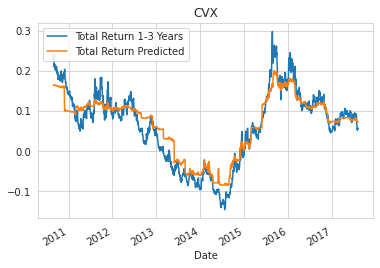

In [42]:
# Column-name for the models' predicted stock-returns.
TOTAL_RETURN_PRED = 'Total Return Predicted'

# Create a DataFrame with actual and predicted stock-returns.
# This is for the training-set.
df_y_train = pd.DataFrame(y_train)
df_y_train[TOTAL_RETURN_PRED] = y_train_pred

# Plot the actual and predicted stock-returns for the first stock.
ticker = tickers_train[0]
_ = df_y_train.loc[ticker].plot(title=ticker)

However, when we tried to plot the model's predicted versus actual stock-returns for the first stock in the test-set, we see that the model is completely unable to predict the stock-returns for the data that it has not seen during its training:

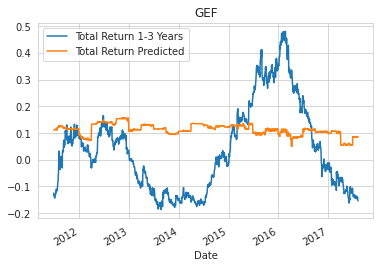

In [43]:
# Create a DataFrame with actual and predicted stock-returns.
# This is for the test-set.
df_y_test = pd.DataFrame(y_test)
df_y_test[TOTAL_RETURN_PRED] = y_test_pred

# Plot the actual and predicted stock-returns for the first stock.
ticker = tickers_test[0]
_ = df_y_test.loc[ticker].plot(title=ticker)

## **Machine Learning: Classification**

Instead of mapping from signals x to a continuous variable y for the stock-return, we also tried and mapped to discrete output-classes that indicate if the stock-return was a gain or loss. 

First we converted the stock-returns into values of either 1.0 for gains or -1.0 for losses, and then split into training- and test-sets:

In [44]:
%%time
# Convert stock-returns to binary classes by taking the sign.
df_cls = np.sign(df_sig_rets[TOTAL_RETURN_1_3Y])

# Split the classes into training- and test-sets.
y_train_cls = df_cls.loc[tickers_train]
y_test_cls = df_cls.loc[tickers_test]

CPU times: user 97.1 ms, sys: 17 ms, total: 114 ms
Wall time: 112 ms


The training-set is biased because it contains many more stocks with gains than losses:

In [45]:
# Fraction of the training-set that is classified as gains.
(y_train_cls == 1.0).sum() / len(y_train_cls)

0.7060543619023089

We instructed the Machine Learning model to take this bias into account, by setting class_weight='balanced', and otherwise use the same arguments as above:

In [46]:
clf = RandomForestClassifier(class_weight='balanced', **model_args)

We then fit the model to the training-data. This is much faster then for the regression model above, because we only have a binary class as output:

In [47]:
%%time
_ = clf.fit(X=X_train, y=y_train_cls)

CPU times: user 14min 54s, sys: 1.66 s, total: 14min 56s
Wall time: 3min 49s


As for the regression model above, the Random Forest consists of 100 Decision Trees, which are basically just nested if-then-else statements that split the input signals, to try and find a mapping that fits the input and output of the training-data.

In [48]:
print_tree(clf)

|--- Log_Revenue <= 8.43
|   |--- P/E <= 7.35
|   |   |--- P/Sales <= 12.72
|   |   |   |--- Market-Cap <= 384131472.00
|   |   |   |   |--- Quick_Ratio <= 0.82
|   |   |   |   |   |--- Asset_Turnover <= 0.15
|   |   |   |   |   |   |--- Net_Profit_Margin <= -0.40
|   |   |   |   |   |   |   |--- truncated branch of depth 4
|   |   |   |   |   |   |--- Net_Profit_Margin >  -0.40
|   |   |   |   |   |   |   |--- truncated branch of depth 3
|   |   |   |   |   |--- Asset_Turnover >  0.15
|   |   |   |   |   |   |--- P/Sales <= 0.33
|   |   |   |   |   |   |   |--- truncated branch of depth 14
|   |   |   |   |   |   |--- P/Sales >  0.33
|   |   |   |   |   |   |   |--- truncated branch of depth 14
|   |   |   |   |--- Quick_Ratio >  0.82
|   |   |   |   |   |--- FCF_Yield <= -0.25
|   |   |   |   |   |   |--- CapEx_/_(Depr_+_Amor) <= 0.29
|   |   |   |   |   |   |   |--- truncated branch of depth 11
|   |   |   |   |   |   |--- CapEx_/_(Depr_+_Amor) >  0.29
|   |   |   |   |   |   |   |-

Below we show the signals (or features) that the model found were most important. These are not necessarily the signals that are best correlated with stock-returns, because the Random Forest is a non-linear mapping from signals to the gain/loss classification.*italicized text*

In [49]:
compare_feature_imp_corr(clf)

,Feature Importance,Return Correlation
Log Revenue,0.048460,0.127872
Market-Cap,0.044521,0.054481
Gross Profit Margin,0.041540,0.011505
Asset Turnover,0.039013,0.030061
Net Profit Margin,0.038656,0.179823
Return on Assets,0.035221,0.169738
Interest Coverage,0.034831,0.012846
CapEx / (Depr + Amor),0.034618,0.036108
Quick Ratio,0.033484,0.042061
Current Ratio,0.032520,0.060111


## **Classification Results**

We then use the fitted model to predict the classes for the training- and test-sets:

In [50]:
%%time
y_train_pred_cls = clf.predict(X_train)
y_test_pred_cls = clf.predict(X_test)

CPU times: user 32.1 s, sys: 254 ms, total: 32.3 s
Wall time: 8.51 s


The model has a very high classification accuracy on the training-set, so the model has learned to map financial signals to gain/loss classifications for 1-3 year investment periods:

In [51]:
accuracy_score(y_true=y_train_cls, y_pred=y_train_pred_cls)

0.9789750084068486

Unfortunately this performance does not generalize to the test-set, which the model has not seen during training. Here the classification accuracy is much lower:

In [52]:
accuracy_score(y_true=y_test_cls, y_pred=y_test_pred_cls)

0.6833877335845839

This is about the same score as simply guessing that the stock-returns are always gains:

In [53]:
# Fraction of the test-set that is classified as gains.
(y_test_cls == 1.0).sum() / len(y_test_cls)

0.6685398299571528

## **Confusion Matrix**
Below is the Confusion Matrix, which shows how the classes were predicted. For the training-set, we again see that the model has learned to accurately classify gains and losses. Note how the colours are different, because the training-set contains many more gains than losses.

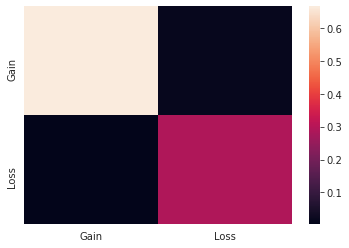

In [54]:
plot_confusion_matrix(y_true=y_train_cls, y_pred=y_train_pred_cls)

The confusion matrix for the test-set, shows that most classes were predicted as gains:

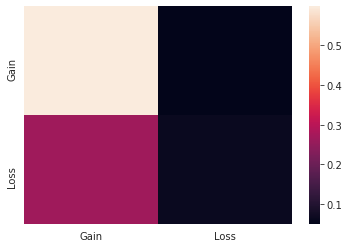

In [55]:
plot_confusion_matrix(y_true=y_test_cls, y_pred=y_test_pred_cls)

In [56]:
from sklearn.metrics import classification_report
print(classification_report(y_test_cls, y_test_pred_cls))

              precision    recall  f1-score   support

        -1.0       0.57      0.19      0.29    118204
         1.0       0.70      0.93      0.80    238412

    accuracy                           0.68    356616
   macro avg       0.63      0.56      0.54    356616
weighted avg       0.65      0.68      0.63    356616



## **Classification Examples**
Below is the plot of the model's predicted versus actual gain/loss classification for a stock in the training-set. 

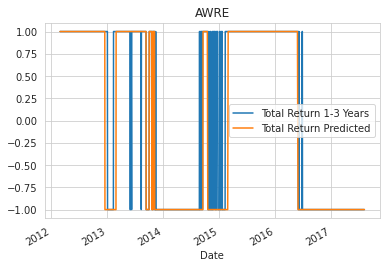

In [57]:
# Create a DataFrame with actual and predicted classifications.
# This is for the training-set.
df_y_train_cls = pd.DataFrame(y_train_cls)
df_y_train_cls[TOTAL_RETURN_PRED] = y_train_pred_cls

# Plot the actual and predicted stock-returns for the first stock.
ticker = tickers_train[22]
_ = df_y_train_cls.loc[ticker].plot(title=ticker)

Below is the plot of the model's predicted versus actual gain/loss classifications for the first stock in the test-set. 

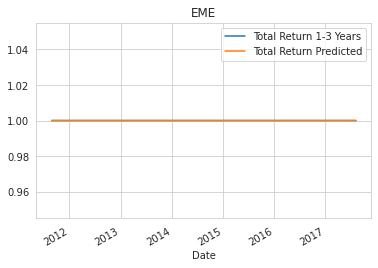

In [58]:
# Create a DataFrame with actual and predicted classifications.
# This is for the test-set.
df_y_test_cls = pd.DataFrame(y_test_cls)
df_y_test_cls[TOTAL_RETURN_PRED] = y_test_pred_cls

# Plot the actual and predicted stock-returns for the first stock.
ticker = tickers_test[22]
_ = df_y_test_cls.loc[ticker].plot(title=ticker)